In [17]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import ShuffleSplit, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectFromModel, RFE
#from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

In [42]:
df = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
df.info()
df['Contract'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [141]:
#df[df['renewed_status']<0].count

<bound method DataFrame.count of       customerID  gender  SeniorCitizen Partner Dependents  tenure  \
11    7469-LKBCI    Male              0      No         No      16   
40    8865-TNMNX    Male              0     Yes        Yes      10   
146   6837-BJYDQ    Male              0      No         No       3   
158   6371-NZYEG    Male              0     Yes        Yes      16   
159   7554-NEWDD    Male              0      No         No      10   
...          ...     ...            ...     ...        ...     ...   
6828  2005-DWQZJ  Female              0     Yes        Yes       8   
6829  8148-WOCMK    Male              0     Yes        Yes       8   
6834  3635-JBPSG  Female              0      No         No      15   
6865  8792-AOROI  Female              0     Yes         No       8   
6958  3078-ZKNTS  Female              0     Yes        Yes      13   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
11            Yes                No          

In [142]:
#df['Contract'].unique()

array([ 1, 12, 24])

In [43]:
# New Feature 1

term_mapping = {
    'Month-to-month': 1,
    'One year': 12,
    'Two year': 24
}
df['Contract'] = df['Contract'].map(term_mapping)
df['renewed_status'] = df['tenure'] - df['Contract']

# New Feature 2
# Calculate the remaining time for one-year contracts
df.loc[df['Contract'] == 12, 'remaining_time'] = 12 - (df['tenure'] % 12)

# Calculate the remaining time for two-year contracts
df.loc[df['Contract'] == 24, 'remaining_time'] = 24 - (df['tenure'] % 24)

# Determine if the contract is near the end (remaining time <= 1 month)
df['near_contract_end'] = df['remaining_time'].apply(lambda x: 'yes' if x <= 1 else 'no')

# New Feature 3
# Convert 'yes'/'no' in StreamingMovies and StreamingTV to 1/0
df['streaming_movies_int'] = df['StreamingMovies'].apply(lambda x: 1 if x == 'yes' else 0)
df['streaming_tv_int'] = df['StreamingTV'].apply(lambda x: 1 if x == 'yes' else 0)

# Add StreamingMovies and StreamingTV usage
df['streaming_total'] = df['streaming_movies_int'] + df['streaming_tv_int']

# Create a binary indicator for Fiber optic (1 if Fiber optic, 0 otherwise)
df['fiber_optic'] = df['InternetService'].apply(lambda x: 1 if x == 'Fiber optic' else 0)

# Calculate the interaction term
df['internet_streaming_interaction'] = df['fiber_optic'] * df['streaming_total']

#df[df['internet_streaming_interaction']!='0']

#New feature 4
df['auto_bill_Yes'] = df['PaymentMethod'].apply(lambda x: 1 if 'automatic' in x.lower() else 0)
df['PaperlessBilling_Yes'] = df['PaperlessBilling'].apply(lambda x: 1 if x == 'yes' else 0)

df['billing_convenience'] = df.apply(lambda row: 2 if row['auto_bill_Yes'] == 1 and row['PaperlessBilling_Yes'] == 1 
                                     else (1 if row['auto_bill_Yes'] == 1 or row['PaperlessBilling_Yes'] == 1 else 0), axis=1)

In [44]:
Variables_provide_by_Maggie = ['renewed_status', 'near_contract_end', 'internet_streaming_interaction', 'billing_convenience']
Variables_highlighted_by_BSteam = ['SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', \
                                   'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Variables_highlighted_by_Leader = ['tenure', 'TotalCharges', 'MonthlyCharges']

Y_Col = ['Churn']
df_ready = df[list(set(Variables_provide_by_Maggie + Variables_highlighted_by_BSteam + Variables_highlighted_by_Leader + Y_Col))].copy()
df_ready

,Contract,InternetService,StreamingMovies,billing_convenience,OnlineSecurity,MonthlyCharges,TotalCharges,Dependents,PaymentMethod,renewed_status,TechSupport,near_contract_end,PaperlessBilling,Partner,tenure,SeniorCitizen,Churn,internet_streaming_interaction
0,1,DSL,No,0,No,29.85,29.85,No,Electronic check,0,No,no,Yes,Yes,1,0,No,0
1,12,DSL,No,0,Yes,56.95,1889.5,No,Mailed check,22,No,no,No,No,34,0,No,0
2,1,DSL,No,0,Yes,53.85,108.15,No,Mailed check,1,No,no,Yes,No,2,0,Yes,0
3,12,DSL,No,1,Yes,42.30,1840.75,No,Bank transfer (automatic),33,Yes,no,No,No,45,0,No,0
4,1,Fiber optic,No,0,No,70.70,151.65,No,Electronic check,1,No,no,Yes,No,2,0,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,12,DSL,Yes,0,Yes,84.80,1990.5,Yes,Mailed check,12,Yes,no,Yes,Yes,24,0,No,0
7039,12,Fiber optic,Yes,1,No,103.20,7362.9,Yes,Credit card (automatic),60,No,no,Yes,Yes,72,0,No,0
7040,1,DSL,No,0,Yes,29.60,346.45,Yes,Electronic check,10,No,no,Yes,Yes,11,0,No,0
7041,1,Fiber optic,No,0,No,74.40,306.6,No,Mailed check,3,No,no,Yes,Yes,4,1,Yes,0


In [45]:
df_ready = df_ready[~df_ready['TotalCharges'].isin([' ', '', '  '])]
df_ready[['MonthlyCharges', 'TotalCharges']] = df_ready[['MonthlyCharges', 'TotalCharges']].astype(float)
df_ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Contract                        7032 non-null   int64  
 1   InternetService                 7032 non-null   object 
 2   StreamingMovies                 7032 non-null   object 
 3   billing_convenience             7032 non-null   int64  
 4   OnlineSecurity                  7032 non-null   object 
 5   MonthlyCharges                  7032 non-null   float64
 6   TotalCharges                    7032 non-null   float64
 7   Dependents                      7032 non-null   object 
 8   PaymentMethod                   7032 non-null   object 
 9   renewed_status                  7032 non-null   int64  
 10  TechSupport                     7032 non-null   object 
 11  near_contract_end               7032 non-null   object 
 12  PaperlessBilling                7032 no

/var/folders/8t/3xrvdszj1g75llc2jb40dnvw0000gn/T/ipykernel_39665/2605809989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ready[['MonthlyCharges', 'TotalCharges']] = df_ready[['MonthlyCharges', 'TotalCharges']].astype(float)


In [46]:

label_ = LabelEncoder()

df1 = df_ready.copy(deep = True)
# to select the columns which are not nummerical
text_data_features = [i for i in list(df_ready.columns) if i not in list(df_ready.describe().columns)]
for i in text_data_features :
    df1[i] = label_.fit_transform(df1[i])
    print(i,' : ', df1[i].unique(),' = ', label_.inverse_transform(df1[i].unique()))


InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Dependents  :  [0 1]  =  ['No' 'Yes']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
near_contract_end  :  [0 1]  =  ['no' 'yes']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
Partner  :  [1 0]  =  ['Yes' 'No']
Churn  :  [0 1]  =  ['No' 'Yes']


In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Contract                        7032 non-null   int64  
 1   InternetService                 7032 non-null   int64  
 2   StreamingMovies                 7032 non-null   int64  
 3   billing_convenience             7032 non-null   int64  
 4   OnlineSecurity                  7032 non-null   int64  
 5   MonthlyCharges                  7032 non-null   float64
 6   TotalCharges                    7032 non-null   float64
 7   Dependents                      7032 non-null   int64  
 8   PaymentMethod                   7032 non-null   int64  
 9   renewed_status                  7032 non-null   int64  
 10  TechSupport                     7032 non-null   int64  
 11  near_contract_end               7032 non-null   int64  
 12  PaperlessBilling                7032 no

In [49]:
mms = MinMaxScaler() # Normalization
#ss = StandardScaler() # Standardization
# the standardscaler is not appliable
numerical_columns = df1.describe().columns
df1[numerical_columns] = mms.fit_transform(df1[numerical_columns])
df1.head()

,Contract,InternetService,StreamingMovies,billing_convenience,OnlineSecurity,MonthlyCharges,TotalCharges,Dependents,PaymentMethod,renewed_status,TechSupport,near_contract_end,PaperlessBilling,Partner,tenure,SeniorCitizen,Churn,internet_streaming_interaction
0,0.000000,0.0,0.0,0.0,0.0,0.115423,0.001275,0.0,0.666667,0.244681,0.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0
1,0.478261,0.0,0.0,0.0,1.0,0.385075,0.215867,0.0,1.000000,0.478723,0.0,0.0,0.0,0.0,0.464789,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,1.0,0.354229,0.010310,0.0,1.000000,0.255319,0.0,0.0,1.0,0.0,0.014085,0.0,1.0,0.0
3,0.478261,0.0,0.0,1.0,1.0,0.239303,0.210241,0.0,0.000000,0.595745,1.0,0.0,0.0,0.0,0.619718,0.0,0.0,0.0
4,0.000000,0.5,0.0,0.0,0.0,0.521891,0.015330,0.0,0.666667,0.255319,0.0,0.0,1.0,0.0,0.014085,0.0,1.0,0.0


In [50]:
# SMOTE
SMOTE_ = SMOTE(sampling_strategy = 1, random_state=42)

#X = df1.iloc[:, :-1].values
X = df1.drop('Churn', axis=1).values
Y = df1['Churn'].values
X, Y = SMOTE_.fit_resample(X, Y)
Counter(Y)

Counter({0.0: 5163, 1.0: 5163})

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [87]:
def model_RFE_importance(BASE_CLF, BASE_CLF_PARA, scoring_method):

    best_score = -np.inf
    best_n_features = None
    best_params = None
    # create RF to select feature importance
    #BASE_RF = RandomForestClassifier()
    # Create the Selction-feature CLF outside the function

    for n_features in range(1, X_train.shape[1] + 1):
        
        # RFE followed by RandomsearchCV 
        RFE_ = RFE(estimator=BASE_CLF, n_features_to_select=n_features)
        
        X_train_rfe = RFE_.fit_transform(X_train, Y_train)
        random_search = RandomizedSearchCV(estimator=BASE_CLF, param_distributions=BASE_CLF_PARA, 
                                        n_iter=20, cv=5, scoring=scoring_method, # the scoring method can be chosen from accuracy to F1-score/recall
                                        random_state=42, n_jobs=-1)
        random_search.fit(X_train_rfe, Y_train)
        
        current_best_score = random_search.best_score_
        current_best_params = random_search.best_params_
        print(f"Number of features: {n_features}, Best {scoring_method} Score: {current_best_score}, Best Params: {current_best_params}")
        
        # Loop to get the best performance
        if current_best_score > best_score:
            best_score = current_best_score
            best_n_features = n_features
            best_params = current_best_params
            best_model = random_search.best_estimator_

        # adjust
        #break

    print("\nBest number of features:", best_n_features)
    print("Best hyperparameters:", best_params)
    print("Best cross-validation {scoring_method} score:", best_score)
    #print(f"Selected Feactures: {RFE_.support_}")
    # return ramdom_search to find the CLF

    return RFE_, random_search, best_model, best_n_features, best_params



In [94]:
def Feature_importance_Visualization(FIV_CLF, feature_names=None):
    if hasattr(FIV_CLF, 'feature_importances_'):
        importances = FIV_CLF.feature_importances_

        # Sorting the indices based on importance values
        indices = np.argsort(importances)[::-1]

        # If no feature names are provided, create a default list
        if feature_names is None:
            feature_names = [f'Feature {i+1}' for i in range(len(importances))]

        # Create the figure
        plt.figure(figsize=(10, 8))
        
        # Switch to horizontal bar plot for better readability
        plt.barh(range(len(importances)), importances[indices], align="center", color="skyblue")

        # Update the y-ticks with feature names in sorted order
        plt.yticks(range(len(importances)), np.array(feature_names)[indices], fontsize=12)
        
        # Add axis labels and title
        plt.xlabel("Importance", fontsize=14)
        plt.ylabel("Features", fontsize=14)
        plt.title("Feature Importances - All Features", fontsize=16)

        # Invert the y-axis to have the most important feature at the top
        plt.gca().invert_yaxis()

        # Add grid lines for better readability
        plt.grid(axis="x", linestyle="--", alpha=0.7)

        # Adjust layout
        plt.tight_layout()

        # Show the plot
        plt.show()
    else:
        print("The classifier does not have feature_importances_ attribute.")

In [88]:
# stacking
base_estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
]

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'gb__n_estimators': [50, 100],
    'gb__learning_rate': [0.01, 0.1, 0.2],
    'final_estimator__C': [0.1, 1, 10]
}

RF_Base = RandomForestClassifier(random_state=42)

Base_param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

#RFE_result = model_RFE_importance(RF_Base, Base_param_grid, 'recall')
# adjust to find the RFE programming
RFE_result, RandomSearch_result, RFE_model, RFE_n_features, RFE_params = model_RFE_importance(RF_Base, Base_param_grid, 'recall')

Number of features: 1, Best recall Score: 0.7772183363538681, Best Params: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
Number of features: 2, Best recall Score: 0.7789135443901496, Best Params: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
Number of features: 3, Best recall Score: 0.8289845440358834, Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True}
Number of features: 4, Best recall Score: 0.8422897312553616, Best Params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': False}
Number of features: 5, Best recall Score: 0.8427739927565723, Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True}
Number of features: 6, Best recall Score: 0.8330957895014215, Best Params: {'n_estimators': 50, 'm

In [129]:
stacking_clf

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

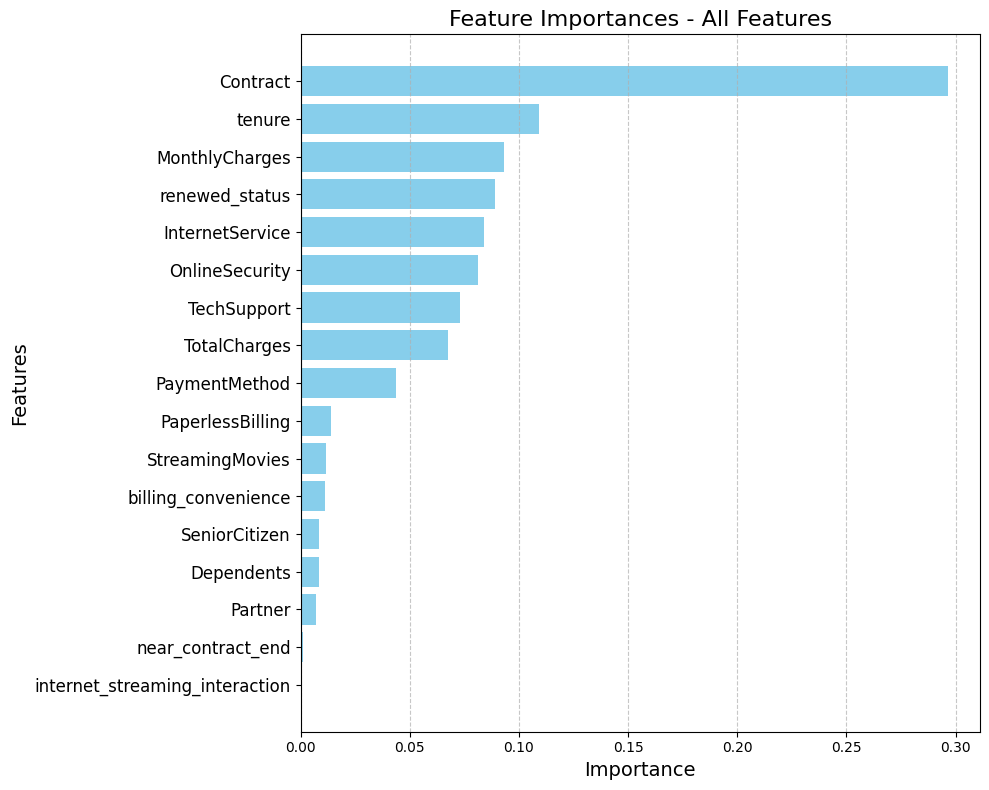

In [95]:
#RFE_model.feature_importances_
# Feature in base CLF visualation
Feature_importance_Visualization(RFE_model, df1.copy().drop(columns='Churn', axis=1).columns[RFE_result.support_])

In [103]:
df1['Churn'].value_counts()

Churn
0.0    5163
1.0    1869
Name: count, dtype: int64

In [104]:
X_train_rfe = RFE_result.fit_transform(X_train, Y_train)
X_test_rfe = RFE_result.transform(X_test)

# test the consumer of 'NO' 'CHURN'
Csonsumer_who_remain = df1[df1['Churn']==0].drop('Churn', axis=1).values

In [105]:
def model_optimize(Result_CLF, param_list, scoring_method):
    random_search = RandomizedSearchCV(estimator=Result_CLF, param_distributions=param_list, 
                                        n_iter=20, cv=5, scoring=scoring_method, # the scoring method can be chosen from accuracy to F1-score/recall
                                        random_state=42, n_jobs=-1)
    random_search.fit(X_train_rfe, Y_train)
    return random_search

def model_evaluation(Evaluated_CLF, sample_test = X_test):
    Y_pred_RFE = Evaluated_CLF.predict(sample_test)
    print(f"Confusion matrix: \n{confusion_matrix(Y_test, Y_pred_RFE)}")
    print(f"Classification Report: \n{classification_report(Y_test, Y_pred_RFE)}")
    print(f"Accuracy: \n{accuracy_score(Y_test, Y_pred_RFE)}")

In [106]:
Stacking_result = model_optimize(stacking_clf, param_grid, 'recall')
model_evaluation(Stacking_result, X_test_rfe)

Confusion matrix: 
[[848 189]
 [153 876]]
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83      1037
         1.0       0.82      0.85      0.84      1029

    accuracy                           0.83      2066
   macro avg       0.83      0.83      0.83      2066
weighted avg       0.83      0.83      0.83      2066

Accuracy: 
0.8344627299128751


In [107]:
# base model contract
RFE_model.set_params(**RFE_params)
RFE_model.fit(X_train_rfe, Y_train)
model_evaluation(RFE_model, X_test_rfe)

# This result reveals that the stacking model has more outstanding performance than only RF model

Confusion matrix: 
[[807 230]
 [148 881]]
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81      1037
         1.0       0.79      0.86      0.82      1029

    accuracy                           0.82      2066
   macro avg       0.82      0.82      0.82      2066
weighted avg       0.82      0.82      0.82      2066

Accuracy: 
0.8170377541142304


In [112]:
# The stacking model predit the consumer, who remain the service, will quit
Num_To_Leave = Stacking_result.predict(Csonsumer_who_remain)
pd.DataFrame(Num_To_Leave).value_counts()

0.0    4744
1.0     419
Name: count, dtype: int64

In [119]:

Num_To_Leave_df = pd.DataFrame(Num_To_Leave, columns=["Predicted_Leave_Status"])


merged_df = pd.concat([df1[df1['Churn']==0].drop('Churn', axis=1), Num_To_Leave_df], axis=1)

merged_df.to_csv("merged_with_predictions_.csv", index=False)

In [121]:
df_ready['Churn']

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
7038     No
7039     No
7040     No
7041    Yes
7042     No
Name: Churn, Length: 7032, dtype: object

In [123]:

new_merged_df = pd.concat([df_ready[df_ready['Churn']=='No'].drop('Churn', axis=1), Num_To_Leave_df], axis=1)
new_merged_df.to_csv("new_merged_with_predictions_before_scaler.csv", index=False)

In [ ]:
#####################################################################################
# END of the analysis

In [161]:
RFE_result.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [164]:
RFE_test_for_debug = RFE(estimator=RF_Base, n_features_to_select=16)
#RF_Base, Base_param_grid, 'recall'
RFE_test_for_debug.fit(X_train, Y_train)
RFE_test_for_debug.support_

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [169]:
df_rfe_columns = df1.copy().drop(columns='Churn', axis=1)
print(f"Remained columns: {list(df_rfe_columns.columns[RFE_test_for_debug.support_])}")
print(f"Dropped columns: {list(set(list(df_rfe_columns)) - set(list(df_rfe_columns.columns[RFE_test_for_debug.support_])))}")

Remained columns: ['near_contract_end', 'TotalCharges', 'PaperlessBilling', 'MonthlyCharges', 'Dependents', 'InternetService', 'Partner', 'billing_convenience', 'Contract', 'SeniorCitizen', 'TechSupport', 'PaymentMethod', 'StreamingMovies', 'OnlineSecurity', 'renewed_status', 'tenure']
Dropped columns: ['internet_streaming_interaction']
